## Open the Dataset

In [1]:
import pandas as pd
import numpy as np

file_path = '/scratch/mch/fackerma/orders/TRT_modelsetup_2/Model_Setup_1.pkl'

df = pd.read_pickle(file_path)


exclude_cols = ['traj_ID', 'timestep', 'Gust_Flag', 'STA_Marker', 'CS_Marker', 'ESWD_Marker']

for col in df.columns:
    if col not in exclude_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['vel_x'] = pd.to_numeric(df['vel_x'], errors='coerce')
df['vel_y'] = pd.to_numeric(df['vel_y'], errors='coerce')

df['velocity'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)


/tmp/ipykernel_121518/312584096.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['velocity'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)


## Check, if Yes and No are spatially separated by 15 minutes for every cell

In [2]:
## Problemativ iDs are stored under problematic_ids


# Only keep rows where Gust_Flag is 'Yes' or 'No'
df_events = df[df['Gust_Flag'].isin(['Yes', 'No'])].copy()

# Ensure timestamp is a datetime type
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'])

# Helper function to check each traj_ID
def check_separation(group):
    # Sort by timestamp
    group = group.sort_values('timestamp')
    # Find indices where Gust_Flag changes
    flag_changes = group['Gust_Flag'] != group['Gust_Flag'].shift()
    change_indices = group.index[flag_changes].tolist()
    # For each transition, check the time difference
    for i in range(1, len(change_indices)):
        idx_prev = change_indices[i-1]
        idx_curr = change_indices[i]
        t_prev = group.loc[idx_prev, 'timestamp']
        t_curr = group.loc[idx_curr, 'timestamp']
        # If the time difference is less than 15 minutes, return False
        if (t_curr - t_prev).total_seconds() < 15*60:
            return False
    return True

# Find traj_IDs with both 'Yes' and 'No'
traj_ids_with_both = df_events.groupby('traj_ID')['Gust_Flag'].nunique()
traj_ids_with_both = traj_ids_with_both[traj_ids_with_both == 2].index

# Check each of these traj_IDs
problematic_ids = []
for traj_id in traj_ids_with_both:
    group = df_events[df_events['traj_ID'] == traj_id]
    if not check_separation(group):
        problematic_ids.append(traj_id)

if problematic_ids:
    print("The following traj_IDs do NOT fulfill the 15-minute separation criterion:")
    print(problematic_ids)
else:
    print("All traj_IDs fulfill the 15-minute separation criterion.")


The following traj_IDs do NOT fulfill the 15-minute separation criterion:
['2022050312350084', '2022051914300101', '2022060405150028', '2022062218250008', '2022062318250074', '2022062410300144', '2022062410300158', '2022062519150106', '2022062713100005', '2022063015100192', '2022063015250206', '2022063015500074', '2022063016550111', '2022063017250012', '2022070317500058', '2022072015050152', '2022072818000158', '2022080516350220', '2022080517000195', '2022080518100153', '2022081715300070', '2022083018350162', '2022090213400004', '2022090308400009', '2022091416450031', '2022092714000010', '2022102318000007', '2023050512000030', '2023050712200125', '2023062015100001', '2023062017350029', '2023062215400123', '2023071003400062', '2023071117300141', '2023071201450125', '2023071203500061', '2023071215050069', '2023071519000155', '2023071810050092', '2023072404400079', '2023072409500205', '2023072412400010', '2023072416000176', '2023072511500127', '2023072516100118', '2023072516450002', '2023

In [3]:
# Exclude problematic IDs (replace with your list) or not...
#filtered_df = df
filtered_df = df[~df['traj_ID'].isin(problematic_ids)]

# Get unique traj_IDs
unique_ids = filtered_df['traj_ID'].unique()

## Make the split

In [4]:
# No stratification
from sklearn.model_selection import train_test_split

# First split: train and temp (70%/30%)
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    random_state=42
)

# Second split: test (20% of total) and validation (10% of total)
test_ids, val_ids = train_test_split(
    temp_ids,
    test_size=0.333,  # 10% / 30% ≈ 0.333
    random_state=42
)


In [20]:
# Stratifiy by majority 'Gust_Flag' for unique_ids

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold


# Get the majority Gust_Flag per traj_ID
majority_flags = filtered_df.groupby('traj_ID')['Gust_Flag'].agg(lambda x: x.mode()[0])  # with '-'

train_ids, temp_ids = train_test_split(
    unique_ids, 
    test_size=0.3, 
    stratify=majority_flags,
    random_state=42
)

# Split temp into test (20% of total) and validation (10% of total)
test_ids, val_ids = train_test_split(
    temp_ids, 
    test_size=0.333,  # 10% / 30% ≈ 0.333
    random_state=42
)




In [16]:
# Stratify by majority 'Gust_Flag' only 'Yes' and 'No' for unique_ids

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold

# Get unique traj_IDs
unique_ids = filtered_df['traj_ID'].unique()

# Get the majority Gust_Flag per traj_ID, excluding '-'
def get_majority_ignore_dash(series):
    filtered = series[series != '-']  # Remove '-' entries
    if filtered.empty:
        return '-'  # Fallback if all values are '-'
    else:
        return filtered.mode()[0]  # Majority of remaining values



majority_flags = filtered_df.groupby('traj_ID')['Gust_Flag'].agg(get_majority_ignore_dash) # without '0'

# Split into train/test/val
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    stratify=majority_flags.loc[unique_ids],  # Use filtered majority_flags
    random_state=42
)

test_ids, val_ids = train_test_split(
    temp_ids,
    test_size=0.333,
    stratify=majority_flags.loc[temp_ids],  # Optional: Stratify here too if needed
    random_state=42
)



In [26]:
# Stratify by the relation of absolute 'Yes' and 'No' rows, but still split the unique_ids


# Count 'Yes' and 'No' per traj_ID
count_df = filtered_df[filtered_df['Gust_Flag'].isin(['Yes', 'No'])] \
    .groupby('traj_ID')['Gust_Flag'] \
    .value_counts() \
    .unstack(fill_value=0) \
    .reset_index()


from sklearn.model_selection import train_test_split
import numpy as np

unique_ids = count_df['traj_ID'].values
yes_counts = count_df['Yes'].values
no_counts = count_df['No'].values

# For stratification, create a 2D array of [yes_count, no_count] for each traj_ID
stratify_labels = np.array([yes_counts, no_counts]).T


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Prepare the stratification matrix (each row: [yes_count, no_count])
X = unique_ids.reshape(-1, 1)  # features (not used, but required)
y = stratify_labels            # labels for stratification

# Split into train (70%) and temp (30%)
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
splits = list(mskf.split(X, y))

# Get indices for the first fold as test, rest as train
train_indices, temp_indices = splits[0][0], splits[0][1]

train_ids = unique_ids[train_indices]
temp_ids = unique_ids[temp_indices]

# Now split temp into test (2/3) and val (1/3) using the same method
temp_X = temp_ids.reshape(-1, 1)
temp_y = stratify_labels[temp_indices]

mskf_temp = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)
splits_temp = list(mskf_temp.split(temp_X, temp_y))

test_indices, val_indices = splits_temp[0][0], splits_temp[0][1]

test_ids = temp_ids[test_indices]
val_ids = temp_ids[val_indices]




In [17]:
# Compute with having an overall balanced 'Yes' to 'No' ratio in every split for unique_ids (70,20,10)

import pandas as pd
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Example: filtered_df is your DataFrame

# Only keep rows with 'Yes' or 'No'
filtered_flags = filtered_df[filtered_df['Gust_Flag'].isin(['Yes', 'No'])]

# Count 'Yes' and 'No' per traj_ID
count_df = (
    filtered_flags
    .groupby('traj_ID')['Gust_Flag']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure both columns exist
for flag in ['Yes', 'No']:
    if flag not in count_df.columns:
        count_df[flag] = 0

unique_ids = count_df['traj_ID'].values
stratify_labels = count_df[['Yes', 'No']].values

# Compute the ratio
total_yes = count_df['Yes'].sum()
total_no = count_df['No'].sum()
overall_ratio = total_yes / total_no if total_no > 0 else 0
print(f"Overall Yes:No ratio = {total_yes}:{total_no} ({overall_ratio:.3f})")

N = len(unique_ids)
train_size = int(N * 0.7)
temp_size = N - train_size

# First split: train vs temp
sss1 = MultilabelStratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=temp_size, random_state=42)
train_idx, temp_idx = next(sss1.split(unique_ids.reshape(-1, 1), stratify_labels))

train_ids = unique_ids[train_idx]
temp_ids = unique_ids[temp_idx]
temp_labels = stratify_labels[temp_idx]

# Second split: test vs val within temp
temp_N = len(temp_ids)
test_size = int(temp_N * 2/3)
val_size = temp_N - test_size

sss2 = MultilabelStratifiedShuffleSplit(n_splits=1, train_size=test_size, test_size=val_size, random_state=42)
test_idx, val_idx = next(sss2.split(temp_ids.reshape(-1, 1), temp_labels))

test_ids = temp_ids[test_idx]
val_ids = temp_ids[val_idx]



Overall Yes:No ratio = 2123:2141 (0.992)


In [5]:
import numpy as np

# Suppose val_ids, train_ids, test_ids are numpy arrays
val_ids = np.array(val_ids)
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)

manual_traj_ids = set(['2019061509450011.0','2021071217550028.0','2021071221500035.0','2021071305200023.0','2022063019350162','2023082417300207'])

# Convert arrays to sets
val_ids_set = set(val_ids)
train_ids_set = set(train_ids)
test_ids_set = set(test_ids)

# Add to validation set
val_ids_set = val_ids_set.union(manual_traj_ids)

# Remove from train and test sets
train_ids_set = train_ids_set - manual_traj_ids
test_ids_set = test_ids_set - manual_traj_ids

# Convert back to numpy arrays or lists if needed
val_ids = np.array(list(val_ids_set))
train_ids = np.array(list(train_ids_set))
test_ids = np.array(list(test_ids_set))


# Map IDs back to full dataframe
train_df = filtered_df[filtered_df['traj_ID'].isin(train_ids)]
test_df = filtered_df[filtered_df['traj_ID'].isin(test_ids)]
val_df = filtered_df[filtered_df['traj_ID'].isin(val_ids)]

train_df = train_df.sort_values(['traj_ID', 'timestamp'])
test_df = test_df.sort_values(['traj_ID', 'timestamp'])
val_df = val_df.sort_values(['traj_ID', 'timestamp'])

# Function to print stats for each split
def print_split_stats(df, name):
    total = len(df)
    unique_ids = df['traj_ID'].nunique()
    yes_count = (df['Gust_Flag'] == 'Yes').sum()
    no_count = (df['Gust_Flag'] == 'No').sum()
    ratio = yes_count / no_count if no_count > 0 else float('inf')
    print(f"{name}:")
    print(f"  Number of rows: {total}")
    print(f"  Number of unique traj_IDs: {unique_ids}")
    print(f"  'Yes' count: {yes_count}")
    print(f"  'No' count: {no_count}")
    print(f"  'Yes':'No' ratio: {yes_count}:{no_count} ({ratio:.3f})")
    print("-" * 40)

# Only keep rows with 'Yes' or 'No'
filtered_flags = filtered_df[filtered_df['Gust_Flag'].isin(['Yes', 'No'])]
# Count 'Yes' and 'No' per traj_ID
count_df = (
    filtered_flags
    .groupby('traj_ID')['Gust_Flag']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

def print_ratio(ids, count_df, name):
    subset = count_df[count_df['traj_ID'].isin(ids)]
    yes = subset['Yes'].sum()
    no = subset['No'].sum()
    ratio = yes / no if no > 0 else 0
    print(f"{name} - Yes:No = {yes}:{no} (ratio: {ratio:.3f})")


print_ratio(unique_ids, count_df, "Full")
print_split_stats(train_df, "Train")
print_split_stats(test_df, "Test")
print_split_stats(val_df, "Validation")


Full - Yes:No = 2123:2141 (ratio: 0.992)
Train:
  Number of rows: 10500
  Number of unique traj_IDs: 1161
  'Yes' count: 1127
  'No' count: 1523
  'Yes':'No' ratio: 1127:1523 (0.740)
----------------------------------------
Test:
  Number of rows: 3395
  Number of unique traj_IDs: 341
  'Yes' count: 414
  'No' count: 390
  'Yes':'No' ratio: 414:390 (1.062)
----------------------------------------
Validation:
  Number of rows: 1859
  Number of unique traj_IDs: 174
  'Yes' count: 208
  'No' count: 228
  'Yes':'No' ratio: 208:228 (0.912)
----------------------------------------


## Train and validate on custom Lags and Lag-Deltas

In [6]:
# 1. Define feature groups (MODIFIED)
features_no_lags = [
                    #'area_p', 
                    #'RANKr',
                    #'dBZmax',
                    #'velocity',
                    #'VIL',
                    #'CG',
                    #'IC',
                    #'rad_shear_max',
                    #'rad_shear_percent_above_2.5',
                    #'rad_shear_percent_above_2',
                    #'rad_shear_percent_above_1.5',
                    #'ZH_com_height', 
                    #'ZH_percent_above_45',
                    #'ZH_percent_above_50',
                    #'ZH_percent_above_55',
                    #'KDP_com_height',
                    #'KDP_percent_above_1',
                    #'KDP_percent_above_1.5',
                    #'KDP_percent_above_2'
                    ]   
features_lags_only = [
                    'area_p', 
                    'RANKr',
                    'dBZmax',
                    'velocity',
                    #'VIL',
                    'CG',
                    'IC',
                    'rad_shear_max',
                    'rad_shear_percent_above_2.5',
                    'rad_shear_percent_above_2',
                    'rad_shear_percent_above_1.5',
                    #'ZH_com_height', 
                    'ZH_percent_above_45',
                    #'ZH_percent_above_50',
                    #'ZH_percent_above_55',
                    #'KDP_com_height',
                    'KDP_percent_above_1',
                    #'KDP_percent_above_1.5',
                    #'KDP_percent_above_2'
                    ]  
features_lags_deltas = [
                    #'area_p', 
                    #'RANKr',
                    #'dBZmax',
                    #'velocity',
                    #'VIL',
                    #'CG',
                    #'IC',
                    #'rad_shear_max',
                    #'rad_shear_percent_above_2.5',
                    #'rad_shear_percent_above_2',
                    #'rad_shear_percent_above_1.5',
                    'ZH_com_height', 
                    #'ZH_percent_above_45',
                    #'ZH_percent_above_50',
                    #'ZH_percent_above_55',
                    'KDP_com_height',
                    #'KDP_percent_above_1',
                    #'KDP_percent_above_1.5',
                    #'KDP_percent_above_2'
                    ] 

              precision    recall  f1-score   support

          No       0.89      0.83      0.86       136
         Yes       0.86      0.91      0.88       156

    accuracy                           0.87       292
   macro avg       0.88      0.87      0.87       292
weighted avg       0.87      0.87      0.87       292

Confusion Matrix:
 [[113  23]
 [ 14 142]]


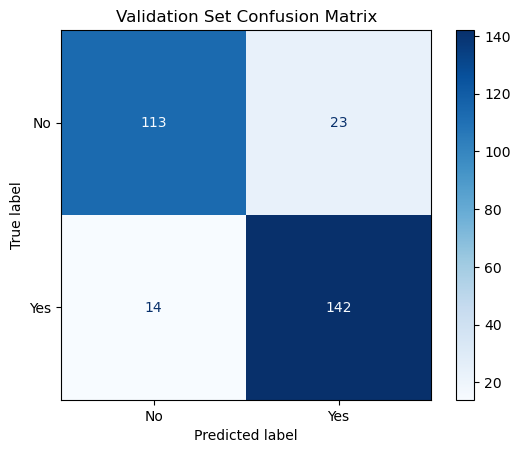

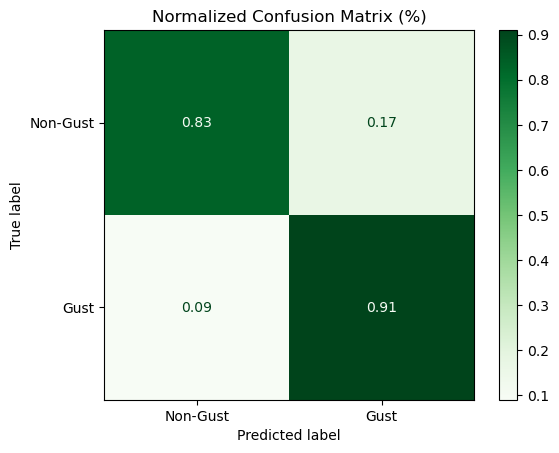

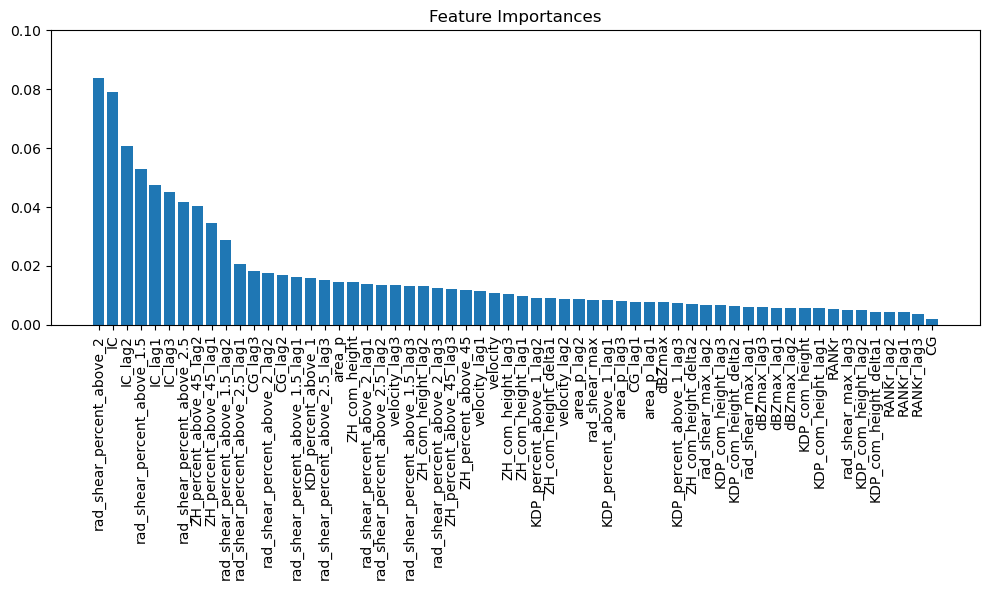

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 2. Create lagged features (MODIFIED)
# For groups that need lags (Groups 2 & 3)
for feature in features_lags_only + features_lags_deltas:
    for lag in range(1, 4):
        train_df[f'{feature}_lag{lag}'] = train_df.groupby('traj_ID')[feature].shift(lag)
        val_df[f'{feature}_lag{lag}'] = val_df.groupby('traj_ID')[feature].shift(lag)


# 3. Create delta features (MODIFIED: Only for Group 3)
for feature in features_lags_deltas:
    train_df[f'{feature}_delta1'] = train_df[f'{feature}_lag1'] - train_df[f'{feature}']
    val_df[f'{feature}_delta1'] = val_df[f'{feature}_lag1'] - val_df[f'{feature}']
    train_df[f'{feature}_delta2'] = train_df[f'{feature}_lag2'] - train_df[f'{feature}']
    val_df[f'{feature}_delta2'] = val_df[f'{feature}_lag2'] - val_df[f'{feature}']
    train_df[f'{feature}_delta3'] = train_df[f'{feature}_lag3'] - train_df[f'{feature}']
    val_df[f'{feature}_delta3'] = val_df[f'{feature}_lag3'] - val_df[f'{feature}']


# 4. Filter rows and prepare features (MODIFIED)
all_features = (
    features_no_lags +
    features_lags_only +
    [f'{f}_lag{l}' for f in features_lags_only for l in range(1, 4)] +
    features_lags_deltas +
    [f'{f}_lag{l}' for f in features_lags_deltas for l in range(1, 4)] +
    [f'{f}_delta{d}' for f in features_lags_deltas for d in range(1, 3)]
)

train_df_events = train_df[train_df['Gust_Flag'].isin(['Yes', 'No'])].copy()
val_df_events = val_df[val_df['Gust_Flag'].isin(['Yes', 'No'])].copy()

# 5. Drop NaNs only for required features (MODIFIED)
train_df_events = train_df_events.dropna(subset=all_features)
val_df_events = val_df_events.dropna(subset=all_features)


# 6. Train Random Forest (UNCHANGED)
X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']
X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']

model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

# 7. Evaluate
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


# 7.1 Confusion Matrix (Add this below your existing evaluation code)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print raw numbers
print("Confusion Matrix:\n", cm)

# Visualize with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay.from_estimator(
    model, 
    X_val, 
    y_val,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show()


import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(all_features)

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.ylim(0, 0.1)
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()
